# Loading dataset

In [1]:
# !pip install ucimlrepo

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wine = fetch_ucirepo(id=109) 
  
# data (as pandas dataframes) 
X = wine.data.features 
y = wine.data.targets 
  
# metadata 
# print(wine.metadata) 
  
# variable information 
wine.variables

,name,role,type,demographic,description,units,missing_values
0,class,Target,Categorical,None,None,None,no
1,Alcohol,Feature,Continuous,None,None,None,no
2,Malicacid,Feature,Continuous,None,None,None,no
3,Ash,Feature,Continuous,None,None,None,no
4,Alcalinity_of_ash,Feature,Continuous,None,None,None,no
5,Magnesium,Feature,Integer,None,None,None,no
6,Total_phenols,Feature,Continuous,None,None,None,no
7,Flavanoids,Feature,Continuous,None,None,None,no
8,Nonflavanoid_phenols,Feature,Continuous,None,None,None,no
9,Proanthocyanins,Feature,Continuous,None,None,None,no


In [2]:
X

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [3]:
y


,class
0,1
1,1
2,1
3,1
4,1
...,...
173,3
174,3
175,3
176,3


# Uncertainty evaluation


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit

# contains some functions for visualizing the results/progress
from exercise_6_iris_utils import *

# plt.style.use('dark_background')

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
def prepare_data(X, y, n_init, use_classes=None, use_features=None, seed=None):
    """Extract classes and features and split data into training, pool, and test sets."""
    
    X = X.to_numpy()  # Ensure NumPy format
    y = y.to_numpy().ravel()  # Flatten target values to 1D

    # Filter classes if needed
    if use_classes is not None:
        use_examples = np.isin(y, use_classes)
        X = X[use_examples]
        y = y[use_examples]

    # Select features if specified
    if use_features is not None:
        X = X[:, use_features]

    n = len(X)
    assert n_init <= n

    # Split into train, pool, and test using stratified sampling
    sss = StratifiedShuffleSplit(n_splits=1, train_size=n_init / n, random_state=seed)
    train_idx, pool_idx = next(sss.split(X, y))

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    pool_idx_, test_idx = next(sss.split(X[pool_idx], y[pool_idx]))

    return dict(
        train=dict(X=X[train_idx], y=y[train_idx]),
        pool=dict(X=X[pool_idx[pool_idx_]], y=y[pool_idx[pool_idx_]]),
        test=dict(X=X[pool_idx[test_idx]], y=y[pool_idx[test_idx]])
    )


In [6]:
def evaluate_uncertainty(prob, strategy):
    """Evaluate the desired uncertainty sampling strategy on predictive
    probabilities 'prob'.

    PARAMETERS
    ----------
    prob : ndarray 
        numpy array with predictive probabilities of shape 
        (n_points, n_classes)
    strategy : str
        One of 'least confident', 'margin', or 'entropy'.

    The function should return an array with uncertainties of shape
    (n_points, ) corresponding to the desired strategy.
    """
    # solution::start
    if strategy == 'least confident':
        res = 1 - prob.max(1)
    elif strategy == 'margin':
        ix = np.arange(len(prob))
        p2, p1 = prob.argsort(1)[:, -2:].T
        res = 1 - (prob[ix, p1] - prob[ix, p2])
    elif strategy == 'entropy':
        res = - np.sum(prob * np.log2(prob), axis=1)
    else:
        raise ValueError
    return res
    # solution::end

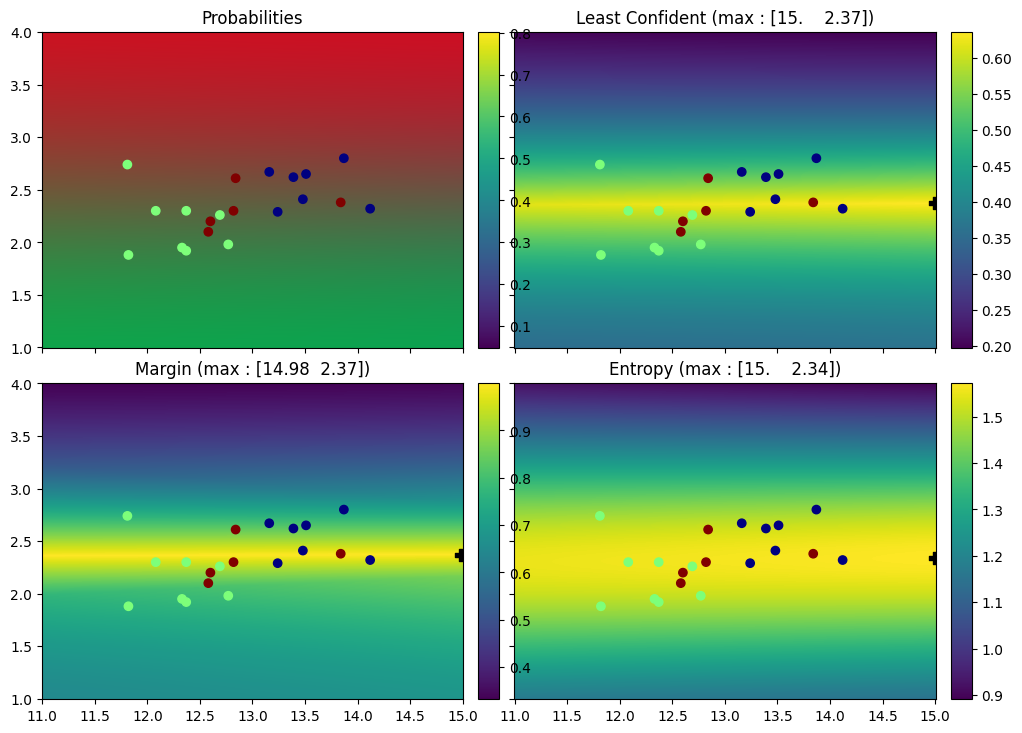

In [7]:
# Example usage
n_init = 20
use_classes = None  # Use all classes
use_features = [0, 2]  # Select specific features (adjust indices as needed)
seed = 0

data = prepare_data(X, y, n_init, use_classes, use_features, seed=seed)

# Fit a logistic classifier
# (While testing this code I experienced some issues with the default
# solver (lbfgs) which is why I use different one here.)
model = LogisticRegression(penalty='l2', C=1e1, solver='liblinear', random_state=seed)
model = model.fit(data['train']['X'], data['train']['y'])

# For the sake of visualization, we are going to create a grid on
# which to evaluate probabilities and uncertainties
grid, imshow_kwargs = make_grid(data['train']['X'], data['pool']['X'])
pool = grid.transpose(1,2,0).reshape(-1, len(use_features))

# Evaluate uncertainties on the `pool` variable

# solution::start

# Compute the predictive probabilities
prob = model.predict_proba(pool)

# Compute the uncertainties
least_confident = evaluate_uncertainty(prob, 'least confident')
margin = evaluate_uncertainty(prob, 'margin')
entropy = evaluate_uncertainty(prob, 'entropy')

# solution::end

# Once calculated, plot the uncertainty metrics
plot_grid(prob, least_confident, margin, entropy, data, grid, imshow_kwargs)

## Active Learning and Random Sampling


In [9]:
def update_data(data, idx):
    """Move a data point from the pool to the training set."""
    data['train']['X'] = np.append(data['train']['X'], np.atleast_2d(data['pool']['X'][idx]), axis=0)
    data['train']['y'] = np.append(data['train']['y'], np.atleast_1d(data['pool']['y'][idx]).ravel(), axis=0)  # Ensure 1D
    data['pool']['X'] = np.delete(data['pool']['X'], idx, axis=0)
    data['pool']['y'] = np.delete(data['pool']['y'], idx, axis=0)


def fit_model(X, y, paradigm, strategy, n_init, n_iterations, use_classes=None, use_features=None, plot=False):
    """Run `n_iterations` of active learning or random sampling.
    
    PARAMETERS
    ----------
    X, y : DataFrame, Series
        Feature matrix and target values.
    paradigm : str
        One of 'active learning' or 'random'.
    strategy : str
        The uncertainty strategy to use (only used when paradigm = 'active learning').
    n_init : int
        The initial number of points in the training set.
    n_iterations : int
        The number of iterations to run.
    use_classes, use_features (same as for prepare_data)
    plot : bool
        Whether to visualize the sampling process.

    RETURNS
    ----------
    scores : ndarray
        The accuracy score at each iteration.    
    """
    # Prepare the dataset
    data = prepare_data(X, y, n_init, use_classes, use_features)
    scores = np.zeros(n_iterations)

    # Initialize model
    model = LogisticRegression(penalty='l2', C=1e1, solver='liblinear', warm_start=True)

    for i in range(n_iterations):
        # 1. Fit the model
        model.fit(data['train']['X'], data['train']['y'])

        # 2. Evaluate on pool
        prob = model.predict_proba(data['pool']['X'])
        scores[i] = model.score(data['test']['X'], data['test']['y'])

        # 3. Select sample based on uncertainty (or random selection)
        if paradigm == 'active learning':
            uncertainty = evaluate_uncertainty(prob, strategy)
            if strategy in ('least confident', 'entropy'):
                idx = uncertainty.argmax()
            elif strategy == 'margin':
                idx = uncertainty.argmin()
            else:
                raise ValueError(f"Unknown strategy: {strategy}")
        elif paradigm == 'random':
            uncertainty = None
            idx = np.random.choice(len(data['pool']['X']))
        else:
            raise ValueError(f"Unknown paradigm: {paradigm}")

        # 4. Update training set and pool
        update_data(data, idx)

        # 5. Plot if requested
        if plot:
            plot_pool(data, idx, uncertainty)

    return scores


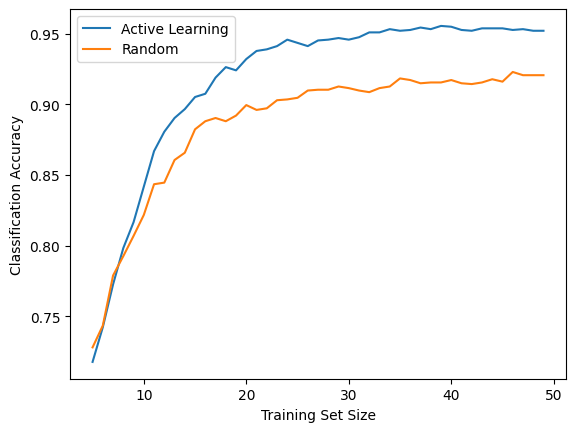

In [10]:

# Settings
n_init = 5
n_iterations = 50 - n_init
n_avg = 50

# Run experiments
scores_al = np.zeros((n_avg, n_iterations))
scores_rn = np.zeros((n_avg, n_iterations))

for i in range(n_avg):
    scores_al[i] = fit_model(X, y, 'active learning', 'entropy', n_init, n_iterations)
    scores_rn[i] = fit_model(X, y, 'random', 'entropy', n_init, n_iterations)

# Plot the results
fig, ax = plt.subplots()
ax.plot(np.arange(n_init, n_iterations + n_init), scores_al.mean(0), label='Active Learning')
ax.plot(np.arange(n_init, n_iterations + n_init), scores_rn.mean(0), label='Random')
ax.legend()
ax.set_xlabel('Training Set Size')
ax.set_ylabel('Classification Accuracy')
plt.show()


In [84]:
import sklearn.metrics

In [88]:
ninit = 20
addn = 2
Xtest=X[100:].to_numpy()
ytest=y[100:].to_numpy().reshape(-1)
Xpool=X[:100].to_numpy()
ypool=y[:100].to_numpy().reshape(-1)
order=np.random.permutation(range(len(Xpool)))

In [89]:
def norm_grad_x(theta,x, C=1.):
    # probability of high class
    # if len(x) > 40:
    #   print(theta*x)
    
    p1 = 1/(1+np.exp(-np.sum(theta*x)))
      # probability of low class
    p0 = 1-p1
      # derivative of cost as derived above for high class
    dL1=-x/(1+np.exp(theta*x))+theta/C
      # same for low class
    dL0=x*np.exp(theta*x)/(1+np.exp(theta*x))+theta/C
      # 2-norm of these
    g1=np.sqrt(np.sum(dL1**2,1))
    g0=np.sqrt(np.sum(dL0**2,1))
      # averaged according to probabilities
    emc=p1*g1+p0*g0
    return emc

In [90]:
# reset training set and pool
testacc_emc=[]
trainset=order[:ninit]
Xtrain=np.take(Xpool,trainset,axis=0)
ytrain=np.take(ypool,trainset,axis=0)
poolidx=np.arange(len(Xpool),dtype=np.int64)
poolidx=np.setdiff1d(poolidx,trainset)

model = LogisticRegression(penalty='l2', C=1e1, solver='liblinear')

for i in range(50):    
    model.fit(Xtrain, ytrain)
    emc=norm_grad_x(model.coef_, Xpool[poolidx])
    ye=model.predict(Xtest)
    testacc_emc.append((len(Xtrain),sklearn.metrics.accuracy_score(ytest,ye)))

    ypool_p_sort_idx = np.argsort(emc)
    Xtrain=np.concatenate((Xtrain,Xpool[poolidx[ypool_p_sort_idx[-addn:]]]))
    ytrain=np.concatenate((ytrain,ypool[poolidx[ypool_p_sort_idx[-addn:]]]))
    poolidx=np.setdiff1d(poolidx,poolidx[ypool_p_sort_idx[-addn:]])
    print('Model: LR, %i samples (EMC)'%(ninit+i*addn))


Model: LR, 20 samples (EMC)
Model: LR, 22 samples (EMC)
Model: LR, 24 samples (EMC)
Model: LR, 26 samples (EMC)
Model: LR, 28 samples (EMC)
Model: LR, 30 samples (EMC)
Model: LR, 32 samples (EMC)
Model: LR, 34 samples (EMC)
Model: LR, 36 samples (EMC)
Model: LR, 38 samples (EMC)
Model: LR, 40 samples (EMC)
Model: LR, 42 samples (EMC)
Model: LR, 44 samples (EMC)
Model: LR, 46 samples (EMC)
Model: LR, 48 samples (EMC)
Model: LR, 50 samples (EMC)
Model: LR, 52 samples (EMC)
Model: LR, 54 samples (EMC)
Model: LR, 56 samples (EMC)
Model: LR, 58 samples (EMC)
Model: LR, 60 samples (EMC)
Model: LR, 62 samples (EMC)
Model: LR, 64 samples (EMC)
Model: LR, 66 samples (EMC)
Model: LR, 68 samples (EMC)
Model: LR, 70 samples (EMC)
Model: LR, 72 samples (EMC)
Model: LR, 74 samples (EMC)
Model: LR, 76 samples (EMC)
Model: LR, 78 samples (EMC)
Model: LR, 80 samples (EMC)
Model: LR, 82 samples (EMC)
Model: LR, 84 samples (EMC)
Model: LR, 86 samples (EMC)
Model: LR, 88 samples (EMC)
Model: LR, 90 sample

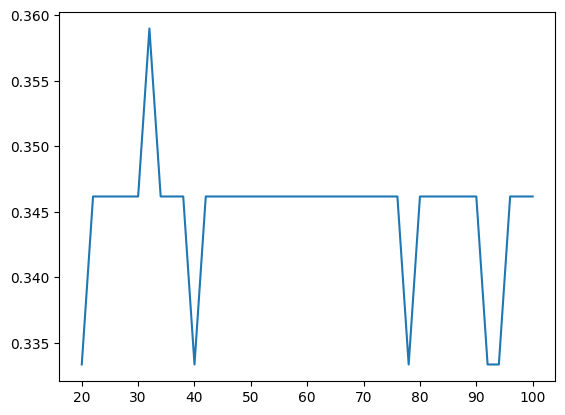

In [91]:
plt.plot(*tuple(np.array(testacc_emc).T))

# 